In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [2]:
df = pd.read_csv("../data/raw/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")

In [3]:
df.shape

(64000, 12)

In [4]:
df.columns

Index(['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code',
       'newbie', 'channel', 'segment', 'visit', 'conversion', 'spend'],
      dtype='object')

In [5]:
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [6]:
df.isnull().sum()

recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
segment            0
visit              0
conversion         0
spend              0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64  
 10  conversion       64000 non-null  int64  
 11  spend            64000 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB


In [9]:
df["segment"].value_counts()

segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64

In [10]:
# create treatment column
df["treatment"] = df["segment"].apply(
    lambda x: 0 if x == "No E-Mail" else 1
)

df["treatment"].value_counts()

treatment
1    42694
0    21306
Name: count, dtype: int64

In [11]:
df["conversion"].value_counts()

conversion
0    63422
1      578
Name: count, dtype: int64

In [12]:
df.isnull().sum()

recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
segment            0
visit              0
conversion         0
spend              0
treatment          0
dtype: int64

In [15]:
df.to_csv("../data/processed/hillstrom_processed.csv",index=False)

In [18]:
# split control and treatment group
control = df[df["treatment"] == 0]
treatment = df[df["treatment"] == 1]

print("Control Size:",len(control))
print("Treatment size:",len(treatment))

Control Size: 21306
Treatment size: 42694


In [24]:
control["conversion"].value_counts(),treatment["conversion"].value_counts()

(conversion
 0    21184
 1      122
 Name: count, dtype: int64,
 conversion
 0    42238
 1      456
 Name: count, dtype: int64)

In [19]:
# calculate conversion rate
control_rate = control["conversion"].mean()
treatment_rate = treatment["conversion"].mean()

print("Control Conversion Rate:",round(control_rate, 4))
print("Treatment Conversion Rate:",round(treatment_rate, 4))

Control Conversion Rate: 0.0057
Treatment Conversion Rate: 0.0107


In [26]:
# calcuate uplift(treatment effect)
uplift = treatment_rate - control_rate
uplift_percent = (uplift/control_rate) * 100

print("Absolute Uplift:",round(uplift,4))
print("Percent Uplift:",round(uplift_percent,2),"%")

Absolute Uplift: 0.005
Percent Uplift: 86.53 %


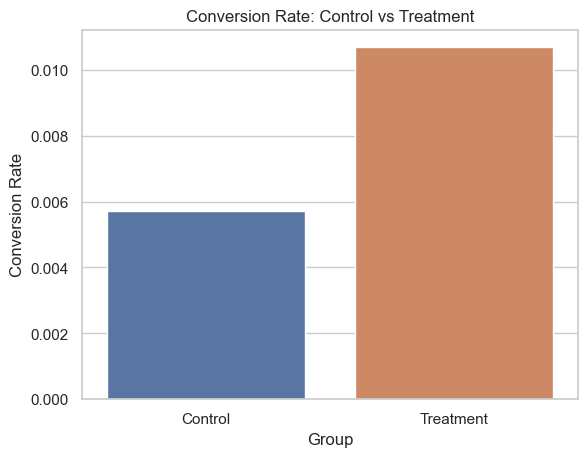

In [28]:
conversion_df = pd.DataFrame({
    "Group":["Control","Treatment"],
    "Conversion Rate": [control_rate,treatment_rate]
})

sns.barplot(data=conversion_df, x="Group", y="Conversion Rate")

plt.title("Conversion Rate: Control vs Treatment")
plt.show()

In [29]:
from scipy.stats import ttest_ind

t_stat,p_value = ttest_ind(
    treatment["conversion"],
    control["conversion"]
)

print("T-statistic:",round(t_stat,4))
print("P-value:",round(p_value,6))

T-statistic: 6.2456
P-value: 0.0


In [30]:
# statistical interpretation 

if p_value < 0.05:
    print("The email has a statiscally significant impact on conversion.")
else:
    print("The effect is not statistically significant.")

The email has a statiscally significant impact on conversion.


In [31]:
import statsmodels.api as sm

control_ci = sm.stats.DescrStatsW(control["conversion"]).tconfint_mean()
treatment_ci = sm.stats.DescrStatsW(treatment["conversion"]).tconfint_mean()

print("Control CI:",control_ci)
print("Treatment CI:",treatment_ci)

Control CI: (0.004712842709186165, 0.006739330387594085)
Treatment CI: (0.009705557346651779, 0.011655758060665407)


In [32]:
# Uplift Modeling

In [33]:
# Copy dateset
uplift_df = df.copy()

# define target and treatment
y = uplift_df["conversion"]
treatment = uplift_df["treatment"]

# drop unnecessary columns
X = uplift_df.drop(columns=["conversion","segment","treatment","visit","spend"],errors="ignore")

# covert categorical variables
X = pd.get_dummies(X,drop_first=True)

print("Feature shape:",X.shape)
X.head()

Feature shape: (64000, 15)


,recency,history,mens,womens,newbie,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,142.44,1,0,0,True,False,False,False,False,False,True,False,True,False
1,6,329.08,1,1,1,False,True,False,False,False,False,False,False,False,True
2,7,180.65,0,1,1,True,False,False,False,False,False,True,False,False,True
3,9,675.83,1,0,1,False,False,False,True,False,False,False,False,False,True
4,2,45.34,1,0,0,False,False,False,False,False,False,False,True,False,True


In [35]:
# train separate Models(T -Learner approach)
from sklearn.ensemble import RandomForestClassifier

# Split data
X_control = X[uplift_df["treatment"] == 0]
y_control = y[uplift_df["treatment"] == 0]

X_treatment = X[uplift_df["treatment"] == 1]
y_treatment = y[uplift_df["treatment"] == 1]

# Train models
model_control = RandomForestClassifier(n_estimators = 100, random_state = 42)
model_treatment = RandomForestClassifier(n_estimators = 100, random_state = 42)

model_control.fit(X_control, y_control)
model_treatment.fit(X_treatment, y_treatment)

RandomForestClassifier(random_state=42)

In [39]:
# Predict probabilities
control_pred = model_control.predict_proba(X)[:,1]
treatment_pred = model_treatment.predict_proba(X)[:,1]

# Calculate uplift score
uplift_score = treatment_pred - control_pred
uplift_df["uplift_score"] = uplift_score
uplift_df[["uplift_score"]].head()

,uplift_score
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [41]:
uplift_df_sorted = uplift_df.sort_values("uplift_score",ascending=False)
uplift_df_sorted[["uplift_score"]].head(10)

,uplift_score
16264,0.87
16530,0.82
25517,0.79
30063,0.79
60802,0.77
36046,0.75
52116,0.74
53958,0.74
6539,0.73
43934,0.73


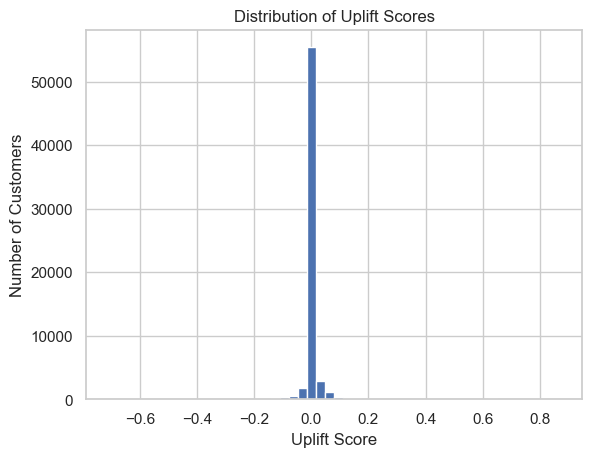

In [42]:
plt.hist(uplift_df["uplift_score"],bins=50)
plt.title("Distribution of Uplift Scores")
plt.xlabel("Uplift Score")
plt.ylabel("Number of Customers")

plt.show()

In [43]:
feature_importance = pd.Series(
    model_treatment.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)

history                           0.827845
recency                           0.088041
zip_code_Urban                    0.013120
zip_code_Surburban                0.012097
newbie                            0.010580
channel_Web                       0.010305
channel_Phone                     0.009473
mens                              0.009147
womens                            0.008517
history_segment_2) $100 - $200    0.003203
dtype: float64

In [44]:
high_uplift = uplift_df[uplift_df["uplift_score"] > uplift_df["uplift_score"].quantile(0.75)]
print("High uplift customers:",len(high_uplift))

High uplift customers: 8885


In [ ]:
uplift_df["uplift_s"]